In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
train = pd.read_csv('C:\\Users\samuel.sisto\Kaggle\StoreItemDemandForecasting\Data\\train.csv', parse_dates=['date'], index_col=['date'])
test = pd.read_csv('C:\\Users\samuel.sisto\Kaggle\StoreItemDemandForecasting\Data\\test.csv', parse_dates=['date'], index_col=['date'])

In [50]:
train.dtypes

store    int64
item     int64
sales    int64
dtype: object

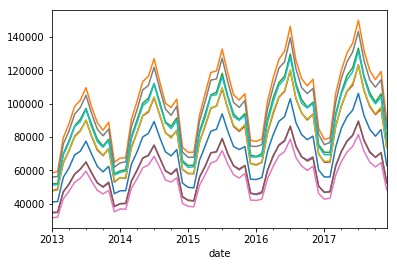

In [56]:
# Number of distinct stores? 10 unique stores
train.store.unique()

# Number of distinct items? 50 unique items
train.item.unique()

# Total number of sales per item, broken down by store
uniq_stores = train.store.unique()
uniq_stores

for x in uniq_stores:
    train[train.store==x].sales.resample('M').sum().plot()

# Total number of sales per store

In [32]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

C:\Users\samuel.sisto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\samuel.sisto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


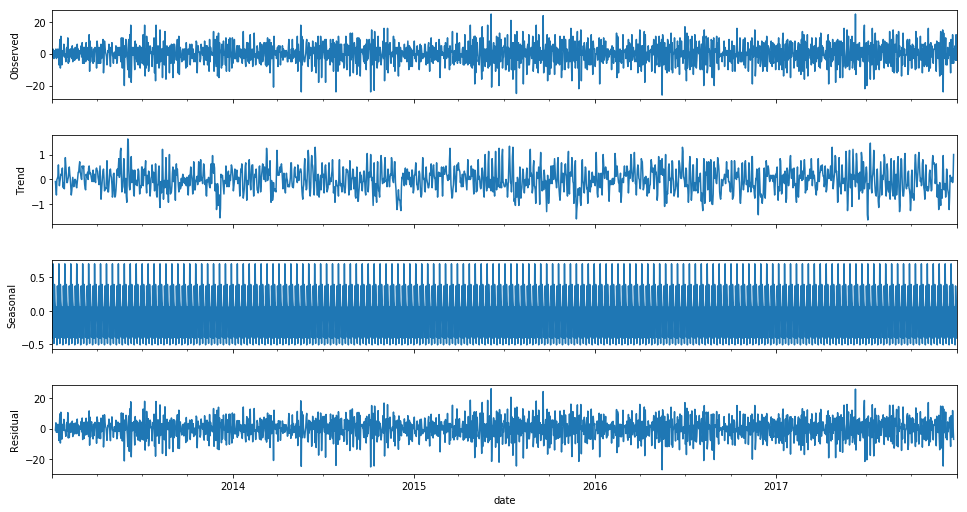

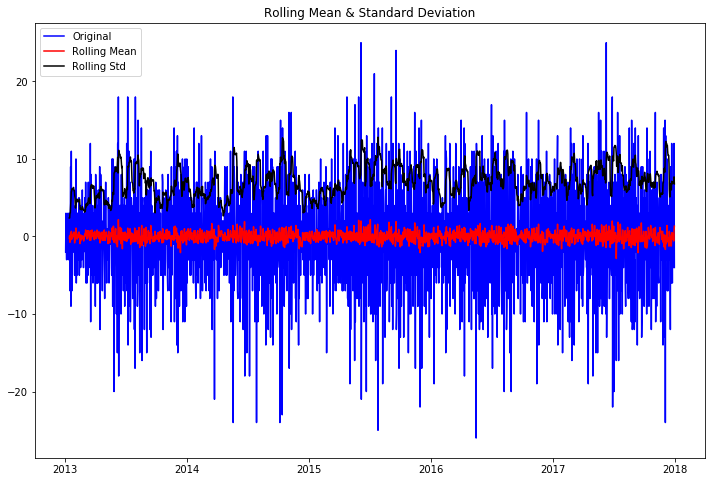

Results of Dickey-Fuller Test:
Test Statistic                -1.267679e+01
p-value                        1.210928e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


In [42]:
# Actual modeling: Moving average, exponential smoothing

train['first_difference'] = train.sales - train.sales.shift(1)

series = train[(train.store==1) & (train.item==1)].first_difference.dropna(inplace=False)
decomposition = seasonal_decompose(series, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

test_stationarity(series)

In [ ]:
#Code to create a submission file?
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q